# Previsão para linhas de ônibus na cidade do Rio de Janeiro

<b>Aluno: Victor Ribeiro </b>
<br>
<b>DRE: 120035521</b>
<br>
<b>Senha: ""

O objetivo deste trabalho é apresentar uma solução em Python que seja capaz de prever:
 - A posição de um ônibus a partir dado um horário
 - O horário a partir da posição do um ônibus

Este relatório tem como objetivo apresentar os resultados obtidos. Devido ao tamanho e complexidade do trabalho, o código está disponível no seguinte repositório do github: (https://github.com/Ribeiro-Victor/coc602-data-mining/tree/main/task_03)

### 1 - Preparação dos dados

Os dados de GPS dos ônibus usados para criar o modelo vieram de arquivos JSON, dividos em intervalos de 1 hora, do dia 25/04/2024 à 10/05/2024. 
Os arquivos de teste usados para fazer a previsão constam do dia 16/05/2024 à 20/05/2024.
Inicialmente, foi necessário carregar os dados do GPS em um banco de dados PostgreSQL usando a extensão PostGIS. Para isso, alguns filtros foram usados para selecionar apenas os dados úteis, diminuindo o tempo de interação com o banco e o tamanho em disco:
- Ao analisar os arquivos de teste, selecionei apenas a linhas que seriam usadas na previsão. Dessa forma, apenas 48 linhas de ônibus do conjunto de arquivos de treino foram utilizadas. As demais, não foram carregadas ao banco.
- Para carregar o banco, transformei os arquivos JSON em planilhas CSV e usei o método COPY do PostgreSQL, diminuindo consideravelmente o tempo de inserção.
- Ao criar a tabela, dividi a mesma em partições por dias, facilitando a execução das consultas na tabela.

O código para essa parte do trabalho pode ser encontrado neste [notebook](./notebooks/load_gps_into_db.ipynb).

### 2 - Identificação das garagens de ônibus

Com o objetivo criar os trajetos de cada linha de ônibus, foi necessário primeiro detectar os ônibus que estavam parados na garagem. Essa identificação permitiu filtrar os dados, removendo os pontos onde os ônibus estavam na garagem ou em trajeto de ida/volta.<br><br>
Para encontrar estes pontos, utilizei apenas os dados onde os ônibus estavam parados (velocidade = 0) e no horário da madrugada (entre 23h-4h). Após coletar estes dados do banco de dados, utilizei o DBScan para criar clusters com um raio de 100 metros. Como resultado, encontrei 21 clusters que eram referentes à garagem de ônibus. Realizei uma dupla checagem, conferindo GoogleMaps/OpenStreetMap e verificando que estes pontos realmente eram garagens. <br>
Obtive o ponto central de cada cluster e inclui em um tabela no banco de dados.

O código para essa parte do trabalho pode ser encontrado neste [notebook](./notebooks/find_bus_garage.ipynb).

### 3 - Identificação dos pontos finais e iniciais para cada linha de ônibus

Para identificar os pontos finais e iniciais para cada linha de ônibus, fiz o seguinte trabalho:
- Selecionei todos os dados do GPS no banco de dados que estavam fora de um raio de 200 metros de qualquer ponto de garagem identificado anteriormente.
- Depois, ordenei os pontos por identificador do ônibus e datahora. Então, para cada intervalo de 10 minutos, se o ônibus permaneceu em um raio de 10 metros, estes pontos na janela de 10 minutos são considerados como potenciais pontos finais. 
- Após esta filtragem, usando os potenciais pontos finais, apliquei o DBscan com um raio de 100 metros. Por conta do filtro anterior, consegui fazer com que pontos de engarrafamento frequente não intereferissem no uso do DBscan e obtive um resultado muito preciso.
- Por fim, para cada linha de ônibus, coloquei os 3 maiores clusters no mapa e verifiquei manualmente quais dois eram os pontos finais. Em geral, a verificação foi fácil pois os dois clusters mais povoados eram realmente os pontos finais. Com exceção das linhas "3" e "878". Esta última, possui um "terceiro" ponto no meio do caminho onde os ônibus fazem uma longa parada perto do metrô do Jardim Oceânico.
Abaixo, um mapa dos pontos finais das linhas.

O código para essa parte do trabalho pode ser encontrado neste [notebook](./notebooks/find_bus_final_stops.ipynb).

![Pontos finais](img/map_all_bus_stops.png)

### 4 - Identificação dos trajetos dos ônibus

Com os pontos finais de cada linha mapeados, foi possível determinar os trajetos de ida e volta dos ônibus. A estrutura para o cálculo dos trajetos de cada linha foi a seguinte:
- Decidi dividir os trajetos entre "WEEKDAY", "SABADO" e "DOMINGO", pois conheço linhas de ônibus que mudam os trajetos aos fins de semana devido ao fechamento de vias.
- Para cada grupo de dias, selecionei do banco de dados as posições de GPS dos dias correspondentes entre 8h e 23h. Depois ordenei as posições por identificador do ônibus e datahora.
- Ao iterar sobre o dataframe, buscava primeiro um ponto que estive em um raio de 20m de um dos pontos finais da linha.
- A partir desse ponto criei uma linestring com todos os pontos até que este mesmo ônibus chegasse ao raio de 20m outro ponto da linha. Assim, obtive um trajeto válido, desconsiderando casos em que houve um salto muito grande de tempo ou distância entre dois pontos consecutivos para um mesmo ônibus.
- Com todos os trajetos identificados, selecionei como o melhor trajeto aquele que possui a distância total do trajeto mais próxima da mediana das distâncias dos trajetos calculados. Essa aproximação forneceu bons resultados, apesar de saber que se conseguisse interpolar mais pontos usando todos os trajetos, conseguria obter uma "LineString" mais precisa para o trajeto.
- Selecionei o melhor trajeto de ida e o de volta e coloquei no banco de dados, para cada linha e cada conjunto de dias. Portanto, cada linha possui 6 trajetos diferentes.
Abaixo, uma representação gráfica de todos os trajetos de "WEEKDAY" para as linhas de ônibus analisadas.

O código para essa parte do trabalho pode ser encontrado neste [arquivo](./notebooks/create_trajectories.py).

![Rotas de ônibus](img/map_all_bus_routes.png)

### 5.1 - Previsão das posições de latitude e longitude

Com os trajetos identificados, a próxima etapa foi prever as posições de latitude e longitude para cada ônibus de cada linha, usando as informações de 2 horas anteriores de trânsito e o timestamp necessário para a previsão. Para isso, executei os seguintes passos para cada linha:
- Carreguei os dados dos trajetos do banco de dados e carreguei as informações sobre o trânsito nas duas horas anteriores.
- A partir dos dados de treino, exclui todos os dados de ônibus que estavam fora de um raio de 60m do trajeto da linha. Portanto, alguns ônibus não fizeram parte da previsão. Estes, em sua maioria, eram ônibus fora do trajeto ou parados em garagens.
- Ordenei o dataframe por identificador do ônibus e datahora, e mantive um rastreamento de cada ônibus nas horas anteriores. Para cada ponto encontrado, fiz a projeção do mesmo no trajeto correspondente (ida ou volta) e calculei iterativamente a distância percorrida em cada intervalo de tempo. Com esses dados, pude estimar as velocidades médias de ida e volta em cada um dos trajetos para a linha, além do tempo médio gasto nos pontos finais e iniciais.
- Para prever as posições pela próxima hora para cada ônibus, utilizei os dados anteriores de velocidade média no trajeto, tempo médio nas paradas e a última posição conhecida. A partir daí, fui calculando as próximas posições como pontos projetados no trajeto correspondente com base na última localização. 
- Portanto, se a última posição conhecida indica que o ônibus estava no trajeto de ida, usando o timestamp fornecido e a velocidade média calculada, obtive a distância que deveria ter sido percorrida neste intervalo de tempo. Com as distâncias calculadas, encontrei os pontos projetados no trajeto de ida até que chegasse ao ponto final. Chegando ao ponto final, sua posição permanece a mesma pelo tempo médio nas paradas identificado anteriormente. Passado este tempo, o ônibus troca de direção e a previsão de posição passa a ser feita da mesma forma, com o trajeto de volta.

O código para essa parte do trabalho pode ser encontrado neste [notebook](./notebooks/predict_lat_long.ipynb).

Abaixo, seguem os resultados (RMSE) obtidos com esse modelo de previsão.

<hr>


Utilizando os dados disponibilizados inicialmente e com arquivo de resposta, calculei o RMSE localmente (sem usar a API). Dessa forma, consegui calcular o RMSE por linha de ônibus e obter um resultado mais direcionado.

![RMSE por datahora](img/RMSE_lat_long.png)

![RMSE por datahora](img/RMSE_lat_long_linhas.png)

Observando o gráfico acima, dividido por linhas, é perceptível que 3 linhas tiveram desempenhos bem distoantes (3, 2336 e 315).
- A Linha 3 foi uma linha problemática desde o início do trabalho, pois não consegui identificar bem os pontos finais da linha e consequentemente os trajetos não devem representar o trajeto real.
- As linhas 2336 e 315 são linhas que fazem o trajeto centro da cidade x zona oeste (campo grande e recreio). Portanto, era de se esperar que o erro em metros fosse maior já que os trajetos também são mais longos.
<hr>

Utilizando a API, o RMSE obtido encontra-se abaixo.

,msg,arquivo teste,rmse,ids não encontrados,ids testados,total na tabela,Proporção testada
0,Problemas!,teste-2024-05-16_08.json,3011.853153,0,156965,165541,94.82%
1,Problemas!,teste-2024-05-16_16.json,2998.117644,0,156337,162697,96.09%
2,Problemas!,teste-2024-05-17_07.json,3409.363729,0,137344,154806,88.72%
3,Problemas!,teste-2024-05-17_15.json,2961.225313,0,156758,162697,96.35%
4,Problemas!,teste-2024-05-18_12.json,2918.393054,0,123925,133500,92.83%
5,Problemas!,teste-2024-05-18_20.json,3045.289407,0,112142,117901,95.12%
6,Problemas!,teste-2024-05-19_11.json,3080.527565,0,87656,95734,91.56%
7,Problemas!,teste-2024-05-19_19.json,2958.340187,0,82685,89258,92.64%
8,Problemas!,teste-2024-05-20_09.json,2511.887960,0,160845,164537,97.76%
9,Problemas!,teste-2024-05-20_17.json,2723.160478,0,152422,158782,95.99%


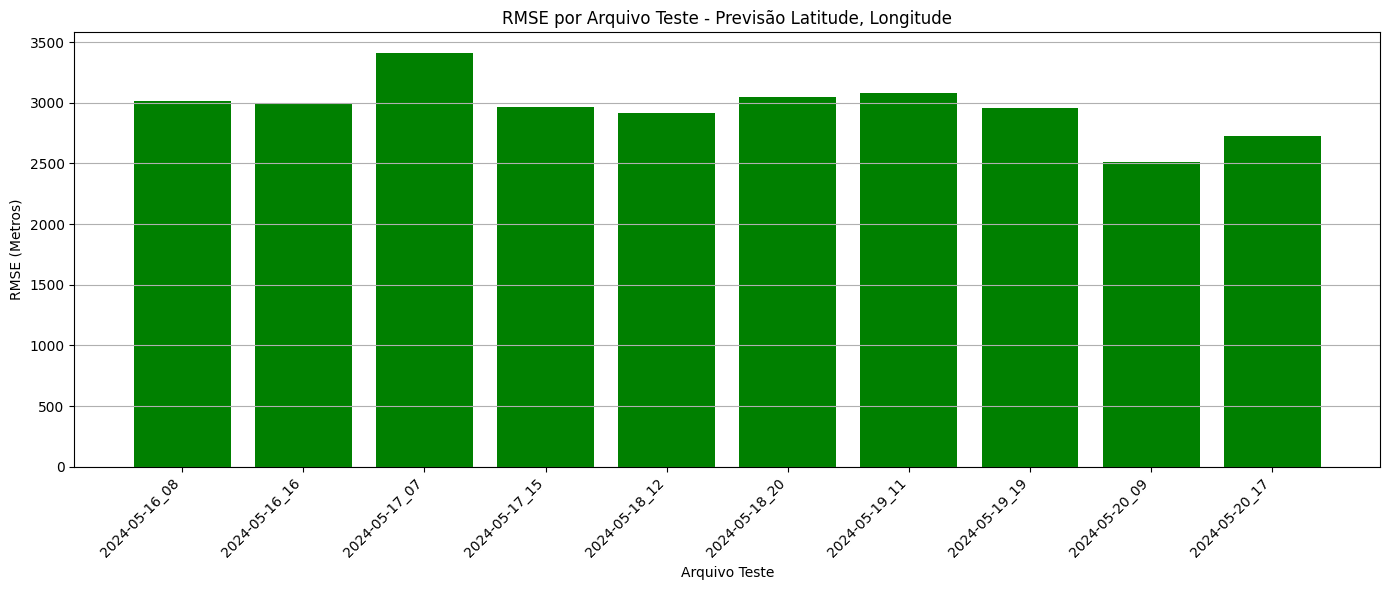

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'api/results_predict_lat_long.csv'
df = pd.read_csv(file_path, index_col=0)
df['Proporção testada'] = ((df['ids testados'] / df['total na tabela']) * 100).apply(lambda x: f"{x:.2f}%")
display(df)

plt.figure(figsize=(14, 6))
df['arquivo teste'] = df['arquivo teste'].str.replace('teste-', '', regex=False)
df['arquivo teste'] = df['arquivo teste'].str.replace('.json', '', regex=False)
plt.bar(df['arquivo teste'], df['rmse'], color='green')

plt.xlabel('Arquivo Teste')
plt.ylabel('RMSE (Metros)')
plt.title('RMSE por Arquivo Teste - Previsão Latitude, Longitude')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Os resultados obtidos pela API são condizentes com o RMSE calculados localmente. O dia 17/05 é um sábado e o RMSE pode ter sido afetado por isso. Apesar disso, todos os dias mantiveram um RMSE parecido. A mensagem recebida da API foi de "Problemas!" pois nem todos os ids foram testados. Porém, isso se deve ao fato de que durante a previsão os outliers foram removidos (distante do trajeto) e suas previsões não calculadas. Mesmo assim, a proporção de teste pareceu boa, acima de 90% em quase todos os casos.

### 5.2 - Previsão dos timestamps

Com os trajetos identificados, a próxima etapa foi prever os timestamps baseado na posição de cada ônibus para todas as linhas, usando as informações de 2 horas anteriores de trânsito. Para isso, executei os seguintes passos para cada linha:
- Carreguei os dados dos trajetos do banco de dados e carreguei as informações sobre o trânsito nas duas horas anteriores.
- A partir dos dados de treino, exclui todos os dados de ônibus que estavam fora de um raio de 60m do trajeto da linha. Portanto, alguns ônibus não fizeram parte da previsão. Estes, em sua maioria, eram ônibus fora do trajeto ou parados em garagens.
- Ordenei o dataframe por identificador do ônibus e datahora, e mantive um rastreamento de cada ônibus nas horas anteriores. Para cada ponto encontrado, fiz a projeção do mesmo no trajeto correspondente (ida ou volta) e calculei iterativamente a distância percorrida em cada intervalo de tempo. Com esses dados, pude estimar as velocidades médias de ida e volta em cada um dos trajetos para a linha, além do tempo médio gasto nos pontos finais e iniciais.
- Para prever o timestamp baseado na posiçaõ do ônibus, utilizei os dados anteriores de velocidade média no trajeto, tempo médio nas paradas e a última posição conhecida. A partir daí, fui calculando os timestamps a partir da velocidade média e a distância entre o último ponto e o ponto fornecido.
- Portanto, se a última posição conhecida indica que o ônibus estava no trajeto de ida, usando a posição fornecida (projetada no trajeto) e a velocidade média calculada, obtive o tempo que o ônibus deveria ter levado para percorrer essa distância. Com os timestamps calculados, encontrei os próximos timestamps no trajeto de ida até que chegasse ao ponto final. Chegando ao ponto final, o timestamp é acrescido de 30s a cada iteração, já que aparentemente é o intervalo de envio dos dados ao servidor. Ao passar o tempo médio de parada, o ônibus troca de direção e a previsão de timestamp passa a ser feita da mesma forma, com o trajeto de volta.

O código para essa parte do trabalho pode ser encontrado neste [notebook](./notebooks/predict_time.ipynb).

Abaixo, seguem os resultados (RMSE) obtidos com esse modelo de previsão.

<hr>

Utilizando os dados disponibilizados inicialmente e com arquivo de resposta, calculei o RMSE localmente (sem usar a API). Dessa forma, consegui calcular o RMSE por linha de ônibus e obter um resultado mais direcionado.

![RMSE por datahora](img/RMSE_timestamp.png)

![RMSE por linhas](img/RMSE_timestamp_linhas.png)

Observando o gráfico acima, dividido por linhas, novamente percebemos duas linhas com RMSE mais alto: 3 e 388. 
- A primeira, explicada anteriormente. 
- A linha 388, assim como as linhas 2336 e 315, faz o trajeto centro x zona oeste(santa cruz). O trajeto longo pode ajudar a explicar o alto valor de erro para previsão do tempo.
<hr>

Utilizando a API, o RMSE obtido encontra-se abaixo.

,msg,arquivo teste,rmse,ids não encontrados,ids testados,total na tabela,Proporção testada
0,Problemas!,teste-2024-05-16_12.json,3434.810839,0,160960,163210,98.62%
1,Problemas!,teste-2024-05-16_20.json,4270.541292,0,160700,162676,98.79%
2,Problemas!,teste-2024-05-17_11.json,3558.742083,0,167022,168655,99.03%
3,Problemas!,teste-2024-05-17_19.json,4267.652467,0,158860,161894,98.13%
4,Problemas!,teste-2024-05-18_08.json,2818.139476,0,116586,126597,92.09%
5,Problemas!,teste-2024-05-18_16.json,3095.303884,0,115346,122920,93.84%
6,Problemas!,teste-2024-05-19_07.json,2695.778011,0,69132,86040,80.35%
7,Problemas!,teste-2024-05-19_15.json,3093.398396,0,83793,89757,93.36%
8,Problemas!,teste-2024-05-20_13.json,3176.677624,0,160195,162255,98.73%
9,Problemas!,teste-2024-05-20_21.json,3653.392196,0,142617,144778,98.51%


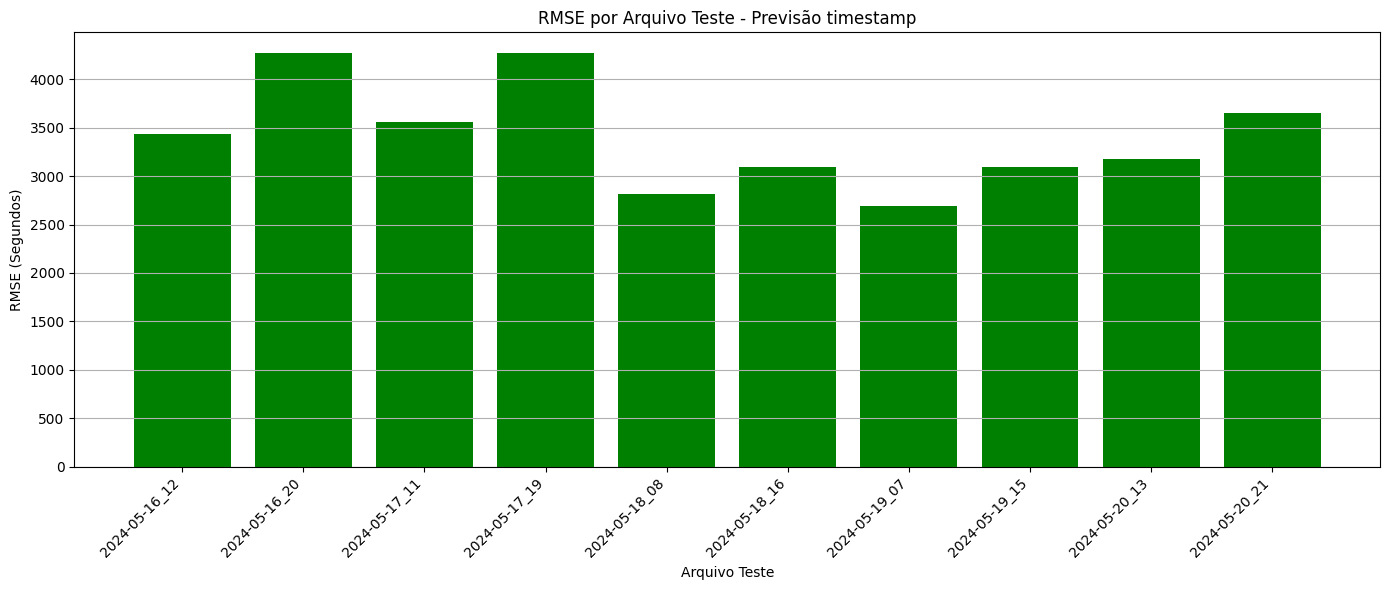

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'api/results_predict_datahora.csv'
df = pd.read_csv(file_path, index_col=0)
df['Proporção testada'] = ((df['ids testados'] / df['total na tabela']) * 100).apply(lambda x: f"{x:.2f}%")
display(df)

plt.figure(figsize=(14, 6))
df['arquivo teste'] = df['arquivo teste'].str.replace('teste-', '', regex=False)
df['arquivo teste'] = df['arquivo teste'].str.replace('.json', '', regex=False)
plt.bar(df['arquivo teste'], df['rmse'], color='green')

plt.xlabel('Arquivo Teste')
plt.ylabel('RMSE (Segundos)')
plt.title('RMSE por Arquivo Teste - Previsão timestamp')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Novamente, os resultados obtidos pela API são condizentes com o teste local. É interessante notar que os horários da noite, em geral tiveram um pior desempenho na previsão.

### 6 - Observações finais

O presente trabalho forneceu um bom entendimento sobre diversos conceitos de mineração de dados, além de mostrar as dificuldades de trabalhar com grandes quantidades de dados, como foi este caso. Os resultados obtido parecem satisfatórios, levando em conta as limitações para a realização do trabalho. 

Ao analisar o resultado final, uma das possíveis melhorias seria criar um modelo mais fidedigno de velocidade, em vez de usar a velocidade média no trajeto inteiro. Se a velocidade média tivesse sido particionada em partes do trajeto, talvez o resultado fosse mais preciso.

Além disso, foi interessante notar que a previsão piora conforme o tempo passa, já que para prever pontos mais distantes do último ponto conhecido, temos menos informações que nos permitam "reposicionar" o modelo no caminho correto. Por isso, em geral, as previsões mais próximas do último ponto conhecido são boas e pioram conforme o tempo passa.